In [1]:
# Source/Reference: https://www.tensorflow.org/tutorials/structured_data/time_series

# Reasoning for explaining TF guides/tutorials: 
# You will become comfortable with reading other tutorials/guides on TF2.0/Keras


# Pre-req:
# - LSTMs, RNNs, GRUs chapter
# - Previous code-walkthrough sessions

In [2]:
#imports

import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# gloabl params for all matplotlib plots
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## Dataset

In [3]:
# ! ls /root/.keras/datasets/

In [4]:
# data is: samples taken every 10 min.

df = pd.read_csv("jena_climate_2009_2016.csv")
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [5]:
df.shape

(420551, 15)

In [6]:
df.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

Observations:
1. One reading every 10 mins
2. 1 day = 6*24 = 144 readings
3. 5 days = 144*5 = 720 readings


**Forecasting task:**  Predict temperature (in deg C) in the future.




In [7]:
# univariate data: Temp vs Time

uni_data_df = df['T (degC)']
uni_data_df.index = df['Date Time']
uni_data_df.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

<Axes: xlabel='Date Time'>

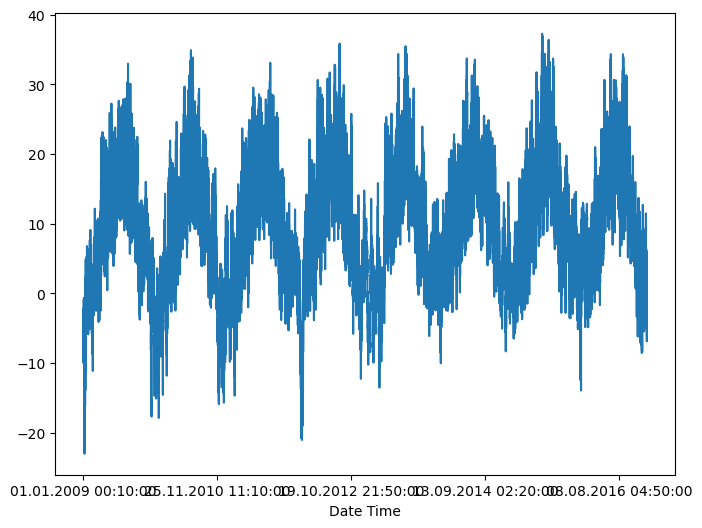

In [8]:
uni_data_df.plot()

In [9]:
uni_data = uni_data_df.values # numpy ndarray from pandas

In [10]:
TRAIN_SPLIT = 300000 # First 300000 obs will be used as train data and rest as test data.
# 300,000 => ~2100 days worth of training data


tf.random.set_seed(13) # random seed 

# Normalize data: mean centering and variance-scaling.
# NOTE: use only train data to normalize all of the data. otherwise, leakage-issue 
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

uni_data = (uni_data-uni_train_mean)/uni_train_std
print(type(uni_data))

<class 'numpy.ndarray'>


## Moving window average

### Pose a simple problem: 
Given last 'k' values of temp-observations (only one feature <=> univariate), predict the next observation

### MWA: 
Average the previous k values to predict the next value.

In [11]:
# This function creates the data we need for the above problem
# dataset: numpy ndarray
# start_index:
# end_index:
# history_size: k => take k values at a time
# target_size: 0 => next value in the time-seriesIN

# Output: data: (n,k) and labels (n,1)

## Each row x_train_uni, x_val_uni contains 20 consecutive values of Y, 
## each y_train_uni, y_val_uni has one next value 20+1
## x=1,20, y=21
## x=2,21, y=22

def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)


# use the above function to create the datasets.
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

print(x_train_uni.shape)
print(y_train_uni.shape)
print(x_val_uni.shape)
print(y_val_uni.shape)



(299980, 20, 1)
(299980,)
(120531, 20, 1)
(120531,)


In [12]:
x_train_uni

array([[[-1.99766294],
        [-2.04281897],
        [-2.05439744],
        ...,
        [-2.08913285],
        [-2.09260639],
        [-2.10418486]],

       [[-2.04281897],
        [-2.05439744],
        [-2.0312405 ],
        ...,
        [-2.09260639],
        [-2.10418486],
        [-2.10418486]],

       [[-2.05439744],
        [-2.0312405 ],
        [-2.02660912],
        ...,
        [-2.10418486],
        [-2.10418486],
        [-2.09492208]],

       ...,

       [[ 0.68738403],
        [ 0.68391049],
        [ 0.68391049],
        ...,
        [ 0.65264863],
        [ 0.65264863],
        [ 0.64801724]],

       [[ 0.68391049],
        [ 0.68391049],
        [ 0.68275265],
        ...,
        [ 0.65264863],
        [ 0.64801724],
        [ 0.6445437 ]],

       [[ 0.68391049],
        [ 0.68275265],
        [ 0.68275265],
        ...,
        [ 0.64801724],
        [ 0.6445437 ],
        [ 0.6445437 ]]])

In [13]:
print ('Single window of past history')
print (x_train_uni[1])
print ('\n Target temperature to predict')
print (y_train_uni[1])

Single window of past history
[[-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]
 [-2.10418486]]

 Target temperature to predict
-2.0949220845536356


In [14]:
#utility function
def create_time_steps(length):
  return list(range(-length,0))

print(create_time_steps(20))

[-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]


### this code plots x_train 1-20, y_train 21

<module 'matplotlib.pyplot' from '/Users/nic/anaconda3/envs/CS7306/lib/python3.11/site-packages/matplotlib/pyplot.py'>

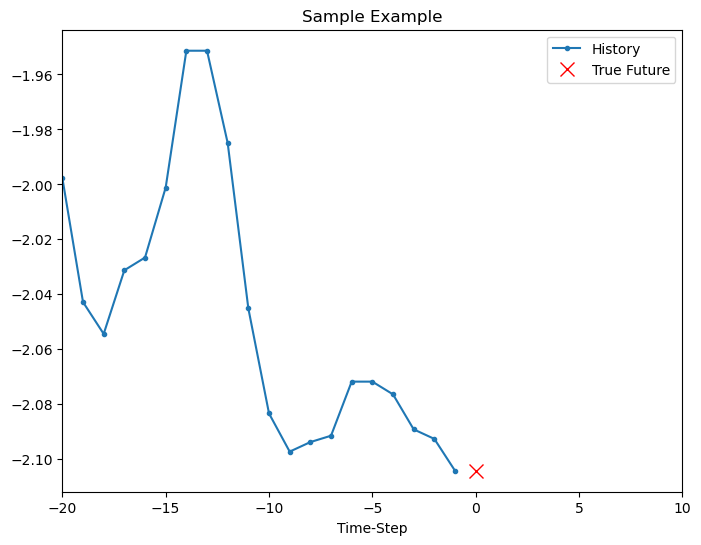

In [15]:
# Plotting function

# plot_data: contains labels as list
# delta: 0 => next time step given last "k" steps.
# title: plot title

# Usage: show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go'] # dot-line, red-x, green-o  refer: https://matplotlib.org/3.1.1/api/markers_api.html
  time_steps = create_time_steps(plot_data[0].shape[0])
  
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt


show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

## this code plots x_train 21-40, y_train 41

<module 'matplotlib.pyplot' from '/Users/nic/anaconda3/envs/CS7306/lib/python3.11/site-packages/matplotlib/pyplot.py'>

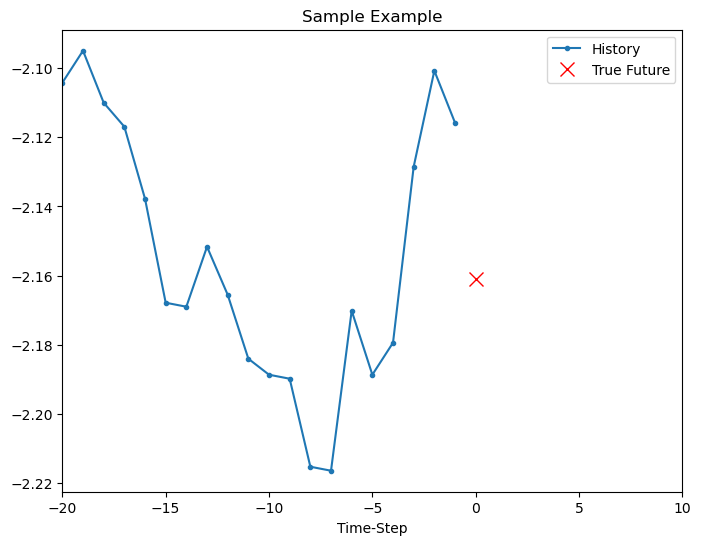

In [16]:
i=20
show_plot([x_train_uni[i], y_train_uni[i]], 0, 'Sample Example')

In [17]:
def mwa(history):
  return np.mean(history)

## this code predicts x_train 21-40, y_train 41 using just mean of train

<module 'matplotlib.pyplot' from '/Users/nic/anaconda3/envs/CS7306/lib/python3.11/site-packages/matplotlib/pyplot.py'>

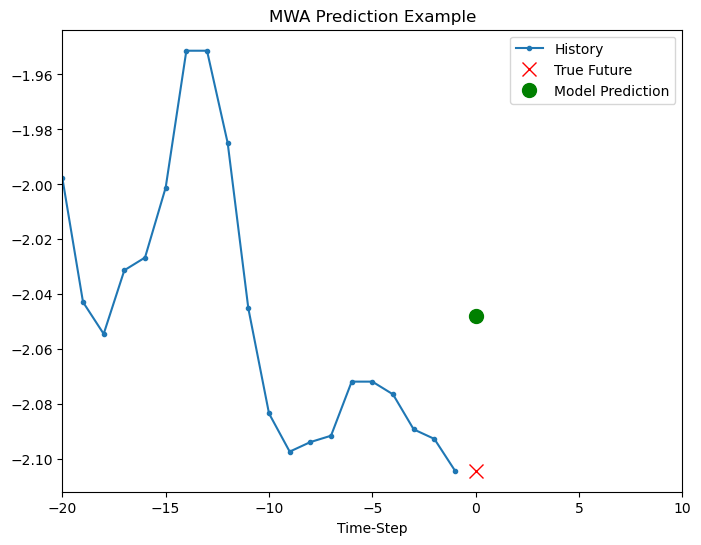

In [18]:
i=0
show_plot([x_train_uni[i], y_train_uni[i], mwa(x_train_uni[i])], 0,
           'MWA Prediction Example')

<module 'matplotlib.pyplot' from '/Users/nic/anaconda3/envs/CS7306/lib/python3.11/site-packages/matplotlib/pyplot.py'>

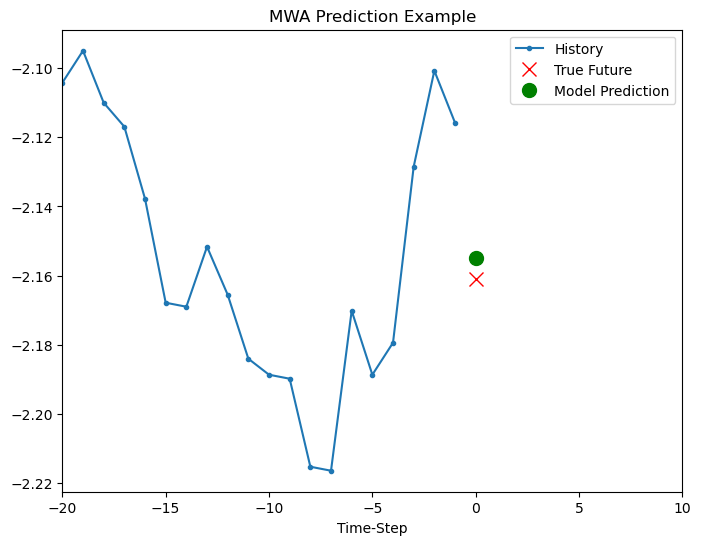

In [19]:
i=20
show_plot([x_train_uni[i], y_train_uni[i], mwa(x_train_uni[i])], 0,
           'MWA Prediction Example')

## Univariate time-series forecasting predict next value, then validate on 5 samples

-  Features from the history: only temperature => univariate

- Problem definition: Given last "k=20" values of temp, predict the next temp value.

In [20]:
# TF Dataset preperation
BATCH_SIZE = 256 # bacth size in batch-SGD/variants
BUFFER_SIZE = 10000 # for shuffling the dataset

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()# defaule is repeated till number of time batch run
#https://www.tensorflow.org/api_docs/python/tf/data/Dataset#repeat

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

print(train_univariate)
print(val_univariate)


<_RepeatDataset element_spec=(TensorSpec(shape=(None, 20, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
<_RepeatDataset element_spec=(TensorSpec(shape=(None, 20, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


 <img src="https://www.tensorflow.org/tutorials/structured_data/images/time_series.png" width="50%" height="50%" />

In [21]:
# MODEL:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

# Why not GRUs?
# https://www.appliedaicourse.com/lecture/11/applied-machine-learning-online-course/3436/grus/8/module-8-neural-networks-computer-vision-and-deep-learning
# https://www.quora.com/Whats-the-difference-between-LSTM-and-GRU

/Users/nic/anaconda3/envs/CS7306/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
# Train and evaluate
STEPS_PER_EPOCH = 200
EPOCHS = 10

# https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=STEPS_PER_EPOCH,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.5845 - val_loss: 0.0626
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0764 - val_loss: 0.0234
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0340 - val_loss: 0.0338
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0360 - val_loss: 0.0440
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0217 - val_loss: 0.0225
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0239 - val_loss: 0.0203
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0262 - val_loss: 0.0216
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0242 - val_loss: 0.0272
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0225 - val_loss: 0.0189
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0214 - val_loss: 0.0168


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


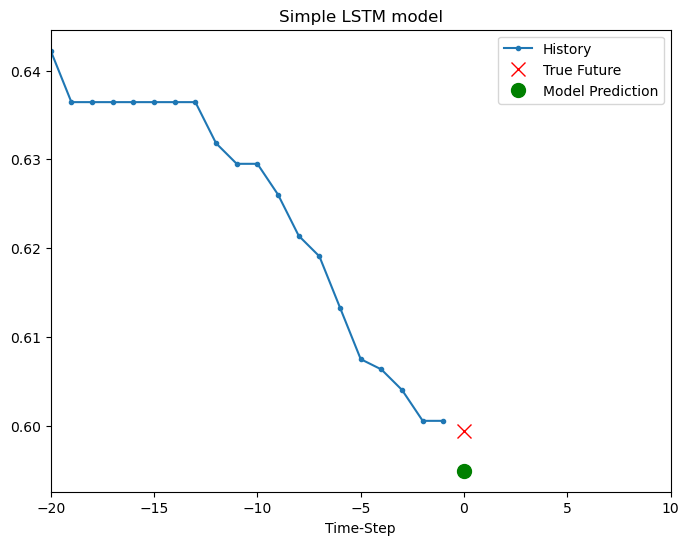

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


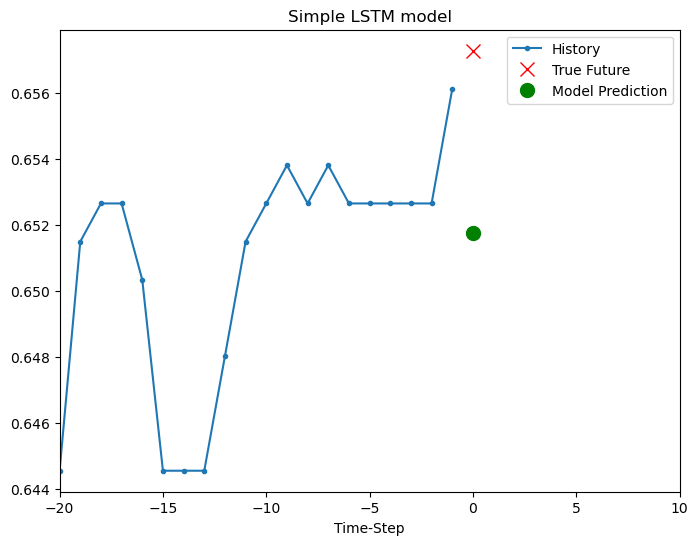

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


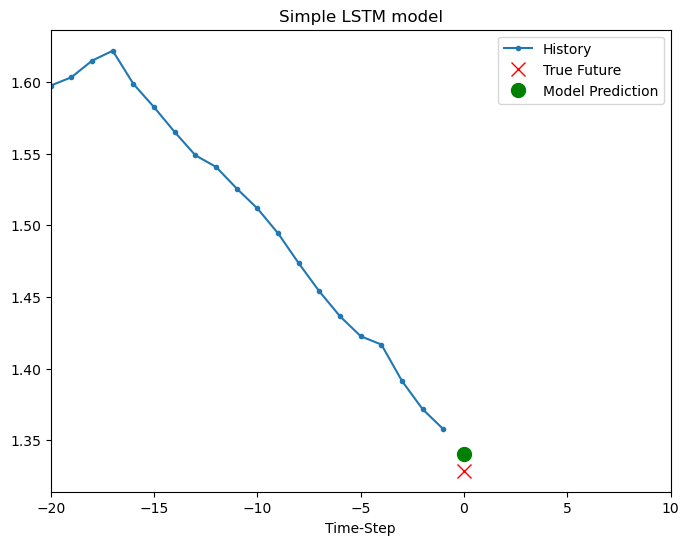

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


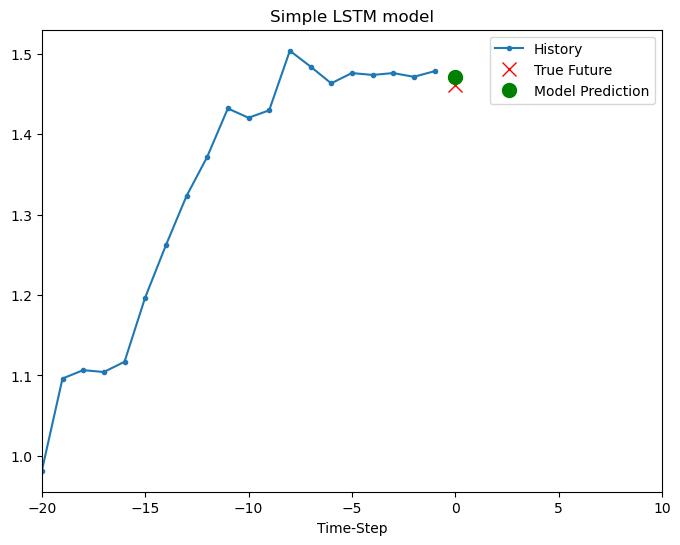

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


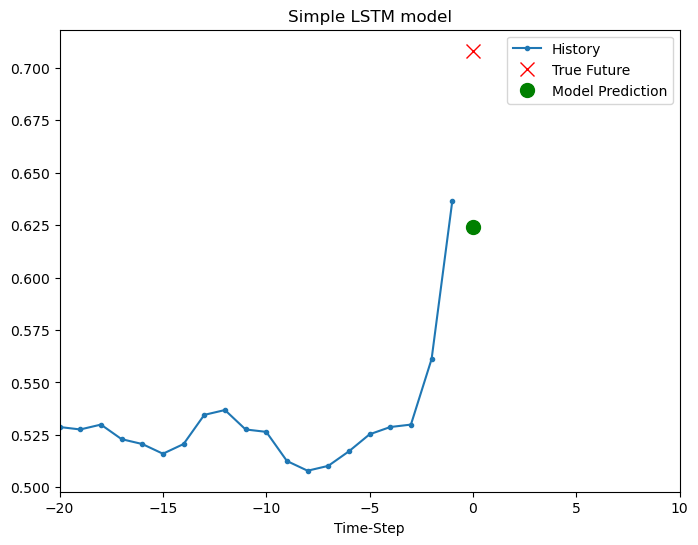

2024-03-17 17:58:20.075133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [23]:

for x, y in val_univariate.take(5): # take 5 random inputs from validation data
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

## Multi-variate & single-step forecasting

- Problem definition: Given three features (p, T, rho) at each time stamp in the past, predict the temperature T at a single time-stamp in the future.

This time, three vars are taken, **that includes histarical target T, predict future T**

In [24]:
# Features
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<Axes: xlabel='Date Time'>, <Axes: xlabel='Date Time'>,
       <Axes: xlabel='Date Time'>], dtype=object)

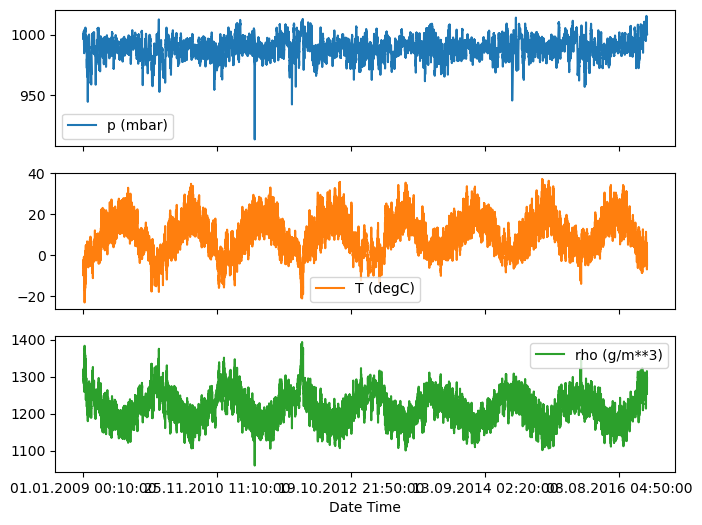

In [25]:
features.plot(subplots=True)

In [26]:
# Standardize data

dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset-data_mean)/data_std

In [27]:
# Same as univariate_data above.
# data is: samples taken every 10 min.

# New params:
# step: instead of taking data for each 10min, you want to generate data once evrey 6 steps (60min)
#### so one sample per hour
# single_step: lables from single timestamp or multiple timesteps

## this code does the same as the above 
##  takes samples of data every step number
## it takes not just one y, but all x and historical T, therefore multivariate
#### y to predict is next y after train+step


def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step) # step used here.
    data.append(dataset[indices])

    if single_step: # single_step used here.
      labels.append(target[i+target_size]) 
    else:
      labels.append(target[i:i+target_size]) 

  return np.array(data), np.array(labels)

######  takes samples of data every step number
###### it takes not just one y, but all x and historical T, therefore multivariate
#### y to predict is next y after train+step


In [41]:
dataset[:]

array([[ 0.95547359, -1.99766294,  2.2350791 ],
       [ 0.96154485, -2.04281897,  2.28524007],
       [ 0.95668784, -2.05439744,  2.29600633],
       ...,
       [ 1.35617678, -1.43494935,  1.76136375],
       [ 1.35496252, -1.55883897,  1.88786728],
       [ 1.35617678, -1.62715193,  1.95686921]])

In [42]:
x_train_single

array([[[ 0.95547359, -1.99766294,  2.2350791 ],
        [ 0.95304508, -1.95134907,  2.18442875],
        [ 0.96883036, -2.09376424,  2.34176293],
        ...,
        [ 0.9627591 , -2.26396773,  2.52919369],
        [ 1.0186147 , -2.3125973 ,  2.59672749],
        [ 1.06475628, -2.45385463,  2.76164698]],

       [[ 0.96154485, -2.04281897,  2.28524007],
        [ 0.95304508, -1.95134907,  2.18467344],
        [ 0.98218713, -2.09144854,  2.34274168],
        ...,
        [ 0.97854438, -2.27438836,  2.54460901],
        [ 1.02711446, -2.32880716,  2.61654719],
        [ 1.07568454, -2.47701156,  2.78978607]],

       [[ 0.95668784, -2.05439744,  2.29600633],
        [ 0.95304508, -1.98492663,  2.22088721],
        [ 0.9906869 , -2.07176515,  2.32365604],
        ...,
        [ 0.98704414, -2.2778619 ,  2.55097089],
        [ 1.02954297, -2.35312194,  2.64321815],
        [ 1.0793273 , -2.49322142,  2.80813764]],

       ...,

       [[ 0.12978217,  0.88884939, -0.88615693],
        [ 0

In [28]:
# Generate data
past_history = 720 # 720*10 mins 
future_target = 72 # 72*10 mins
STEP = 6 # one obs every 6X10min = 60 min => 1 hr

# past history: 7200 mins => 120 hrs, sampling at ones sample evry hour, so 120 samples each 2 vars 
# future_target: 720 mins = > 12 hrs in the future, not next hour

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)
print(x_train_single)
print(x_train_single.shape)
print(y_train_single.shape)

# print(x_train_single[0])
# print(y_train_single[0])


[[[ 0.95547359 -1.99766294  2.2350791 ]
  [ 0.95304508 -1.95134907  2.18442875]
  [ 0.96883036 -2.09376424  2.34176293]
  ...
  [ 0.9627591  -2.26396773  2.52919369]
  [ 1.0186147  -2.3125973   2.59672749]
  [ 1.06475628 -2.45385463  2.76164698]]

 [[ 0.96154485 -2.04281897  2.28524007]
  [ 0.95304508 -1.95134907  2.18467344]
  [ 0.98218713 -2.09144854  2.34274168]
  ...
  [ 0.97854438 -2.27438836  2.54460901]
  [ 1.02711446 -2.32880716  2.61654719]
  [ 1.07568454 -2.47701156  2.78978607]]

 [[ 0.95668784 -2.05439744  2.29600633]
  [ 0.95304508 -1.98492663  2.22088721]
  [ 0.9906869  -2.07176515  2.32365604]
  ...
  [ 0.98704414 -2.2778619   2.55097089]
  [ 1.02954297 -2.35312194  2.64321815]
  [ 1.0793273  -2.49322142  2.80813764]]

 ...

 [[ 0.12978217  0.88884939 -0.88615693]
  [ 0.11156839  0.87842877 -0.88126317]
  [ 0.08242634  0.88190231 -0.89178474]
  ...
  [ 0.47584401  0.68391049 -0.60696829]
  [ 0.52198559  0.66770064 -0.57956327]
  [ 0.54869914  0.65612217 -0.56219044]]

 [

In [29]:
#TF dataset

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

print(train_data_single)
print(val_data_single)

<_RepeatDataset element_spec=(TensorSpec(shape=(None, 120, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
<_RepeatDataset element_spec=(TensorSpec(shape=(None, 120, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


In [30]:
# Model
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=STEPS_PER_EPOCH,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10


/Users/nic/anaconda3/envs/CS7306/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 46s 208ms/step - loss: 0.3810 - val_loss: 0.2529
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 48s 238ms/step - loss: 0.2704 - val_loss: 0.2716
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 42s 209ms/step - loss: 0.2696 - val_loss: 0.3366
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 44s 220ms/step - loss: 0.2631 - val_loss: 0.2603
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 201ms/step - loss: 0.2219 - val_loss: 0.2678
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 45s 224ms/step - loss: 0.2443 - val_loss: 0.2855
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 43s 213ms/step - loss: 0.2446 - val_loss: 0.2299
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 44s 218ms/step - loss: 0.2422 - val_loss: 0.2708
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 50s 247ms/step - loss: 0.2480 - val_loss: 0.2317
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 44s 218ms/step - loss: 0.2534 - val_loss: 0.2560


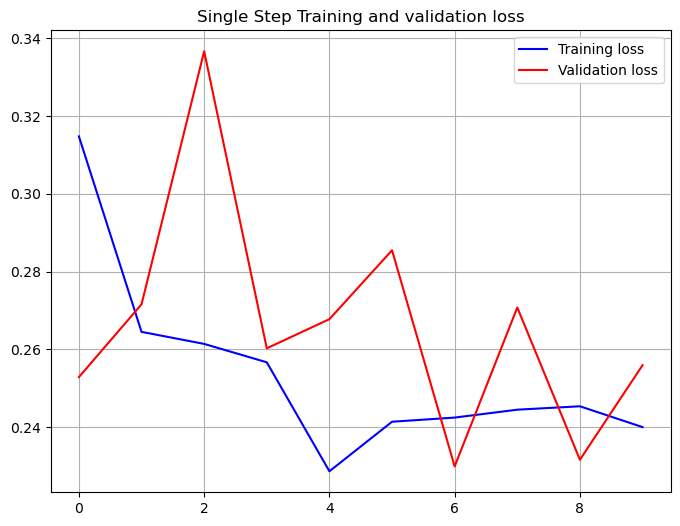

In [31]:
# Plot train and validation loss over epochs

def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()
  plt.grid()

  plt.show()



plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


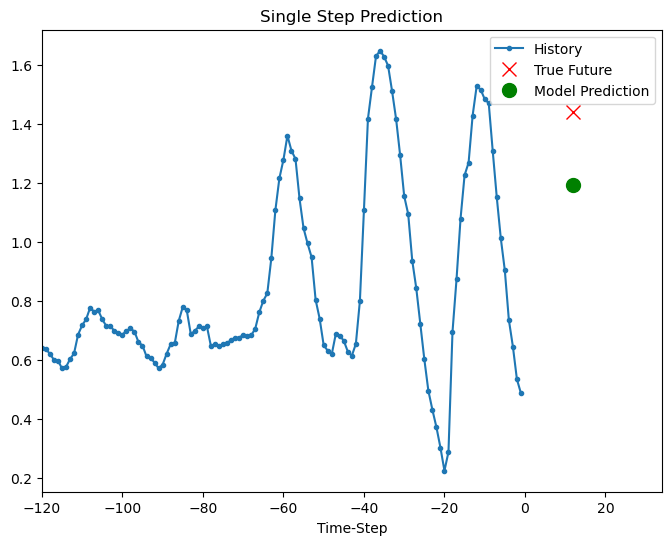

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


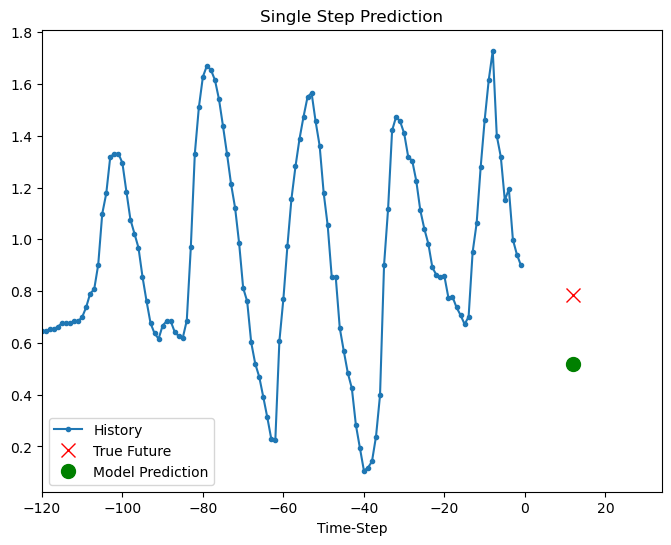

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


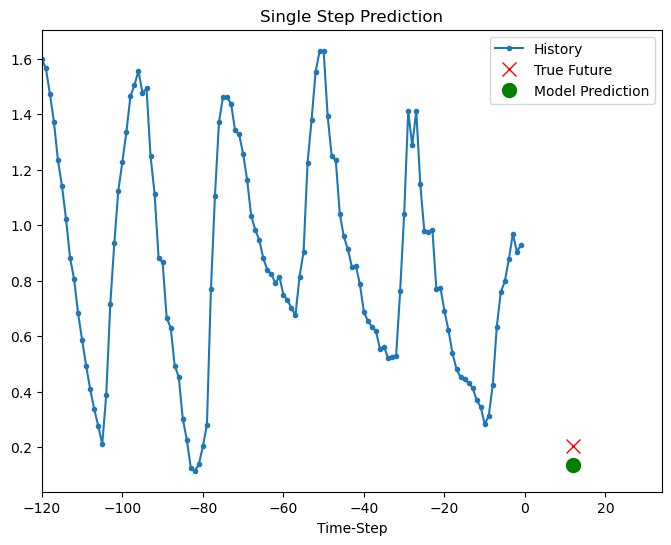

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


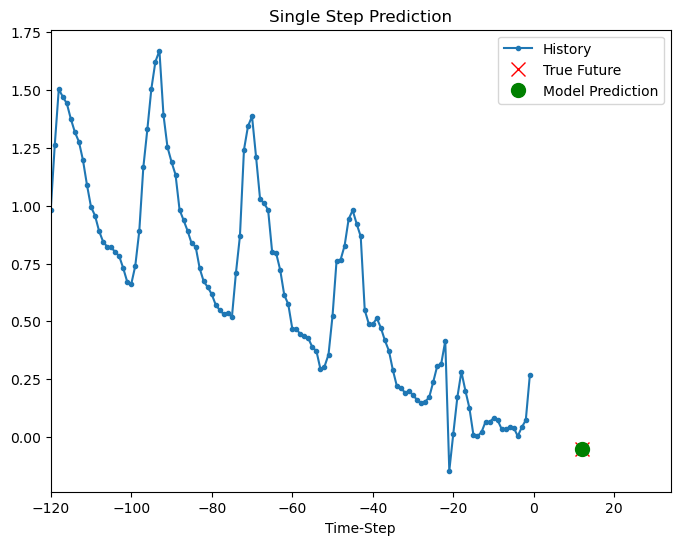

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


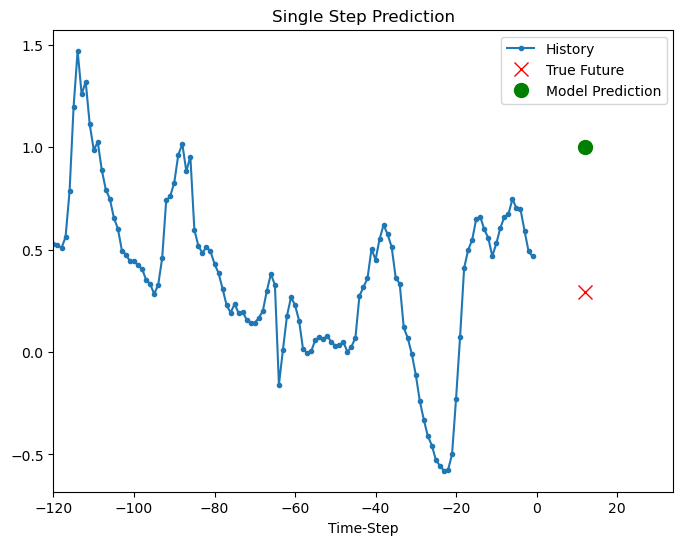

2024-03-17 18:06:23.563560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [32]:
# plot time series and predicted values

####### the y to predict is future_target away from the last x sample, deined here as 72 *10 min = 12hrs

for x, y in val_data_single.take(5):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()


## Multi-variate & multi-step forecasting
- Generate multiple future values of temperature

**here we predict 72 values, so 12 hours into the future, starting after last step, so 1 hour**

In [33]:
# single_step=FALSE default value

future_target = 72 # 72 future values
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

print(x_train_multi.shape)
print(y_train_multi.shape)
print(x_val_multi.shape)
print(y_val_multi.shape)

(299280, 120, 3)
(299280, 72)
(119759, 120, 3)
(119759, 72)


In [34]:
# TF DATASET

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

2024-03-17 18:06:45.627236: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


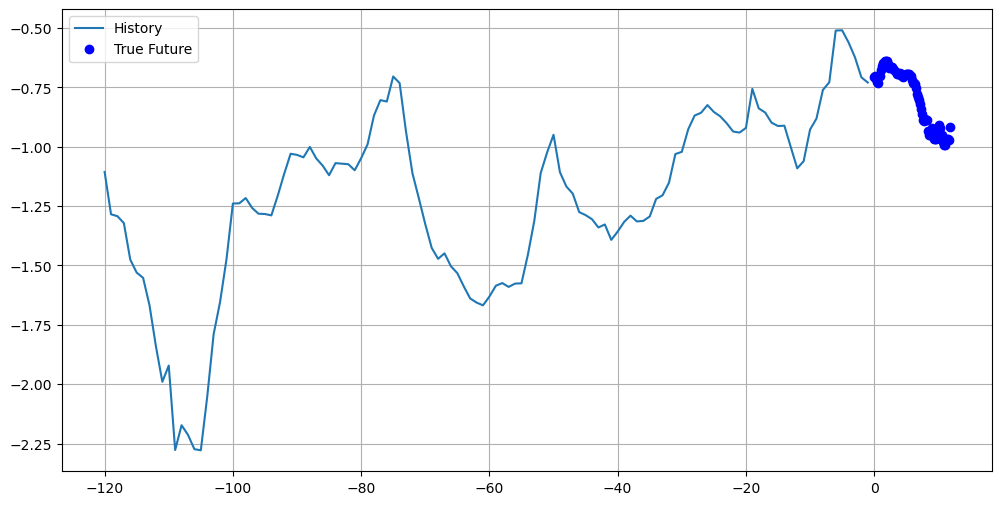

2024-03-17 18:06:45.932205: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [35]:
#plotting function
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
  plt.grid()
  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()
  


for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [36]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72)) # for 72 outputs

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=STEPS_PER_EPOCH,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10


200/200 ━━━━━━━━━━━━━━━━━━━━ 59s 278ms/step - loss: 0.6539 - val_loss: 0.3030
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 60s 301ms/step - loss: 0.3395 - val_loss: 0.2590
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 58s 288ms/step - loss: 0.3378 - val_loss: 0.3454
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 52s 263ms/step - loss: 0.2592 - val_loss: 0.2518
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 73s 368ms/step - loss: 0.2028 - val_loss: 0.2341
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 69s 347ms/step - loss: 0.2152 - val_loss: 0.2297
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 69s 346ms/step - loss: 0.2098 - val_loss: 0.2036
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 63s 313ms/step - loss: 0.2049 - val_loss: 0.2290
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 48s 239ms/step - loss: 0.2097 - val_loss: 0.1849
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 45s 225ms/step - loss: 0.2047 - val_loss: 0.2125


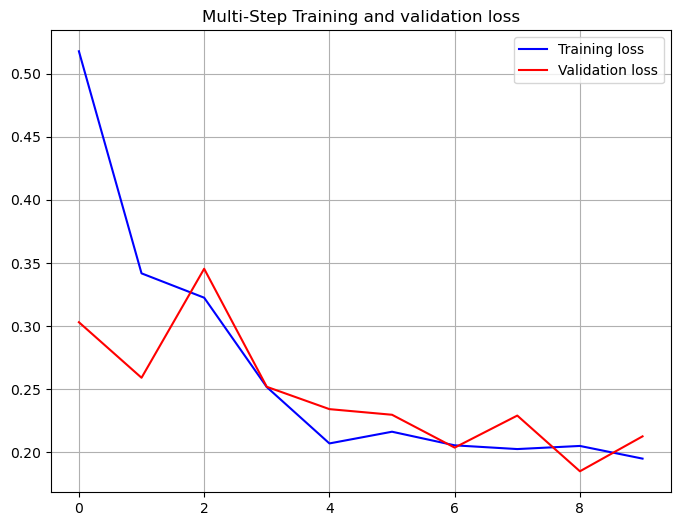

In [37]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


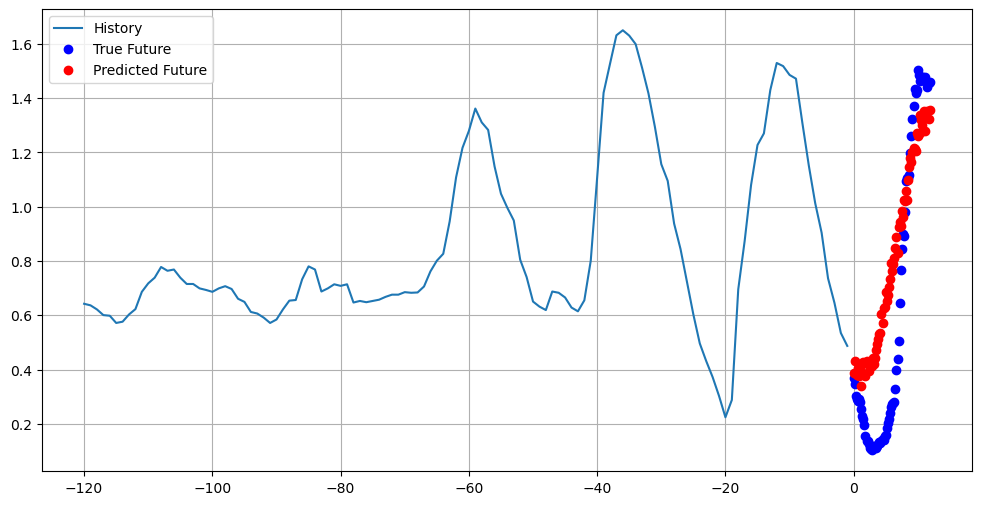

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


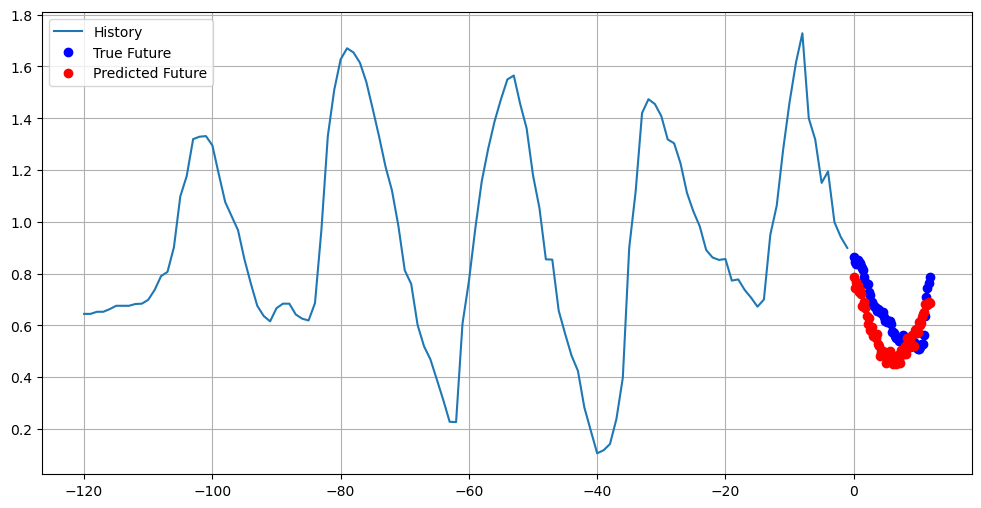

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


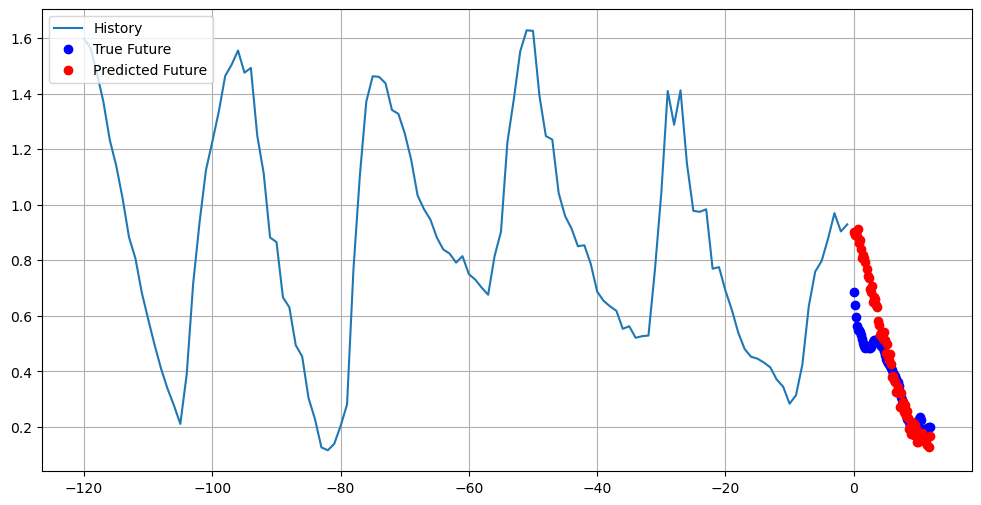

2024-03-17 18:16:44.799500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [38]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])